In [1]:
import torch
import numpy as np
import pandas as pd
import DNN_utils as utils
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from datetime import datetime
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import gc
from importlib import reload

In [2]:
# IF EXECUTING ON COLLAB UNCOMMENT THIS CELL

#import os
#from google.colab import drive
#drive.mount('/content/gdrive')
#folder = '/content/gdrive/My Drive/Data ML Project'
#os.chdir(folder)
#print(torch.cuda.is_available())

# Set these right after importing torch, before any other operations
torch.set_num_threads(os.cpu_count())
torch.set_num_interop_threads(os.cpu_count())
path = 'Targets/daily_crsp_sanitized.csv'

In [3]:
daily = utils.read_daily_returns(path, nrows=2000000, low_quantile=0.005, up_quantile=0.995)
daily

Number of daily return outliers: 18,415


,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,sprtrn_lag1
0,2000-01-31,5,15580,6320,0,-0.068182,0.025218,0.000000
1,2000-01-31,7,14593,3573,0,0.020910,0.025218,0.000000
2,2000-01-31,25,62770,6711,0,0.041045,0.025218,0.000000
3,2000-01-31,29,59184,2082,0,0.011236,0.025218,0.000000
4,2000-01-31,33,59248,2082,0,0.034667,0.025218,0.000000
...,...,...,...,...,...,...,...,...
1841513,2000-12-13,16265,86321,6310,0,0.057471,-0.008161,-0.006535
1841514,2000-12-13,16266,86324,7370,0,-0.063291,-0.008161,-0.006535
1841515,2000-12-13,16267,86337,3660,0,-0.101449,-0.008161,-0.006535
1841516,2000-12-13,16268,86339,4899,0,0.009456,-0.008161,-0.006535


In [4]:
# Get data frame of unique months
daily['year_month'] = daily['date'].dt.to_period('M')
unique_months = daily['year_month'].drop_duplicates().sort_values()
unique_months

0          2000-01
8329       2000-02
174757     2000-03
365885     2000-04
523862     2000-05
706883     2000-06
889939     2000-07
1056371    2000-08
1248826    2000-09
1415409    2000-10
1598244    2000-11
1771577    2000-12
Name: year_month, dtype: period[M]

In [5]:
# Keeping track of the return over all the data
reload(utils)
all_strategy_returns = []

for i in range(0, len(unique_months) - 6):

    # Train on 6 months of data and test on 1 month
    train_start = unique_months.iloc[i]
    train_end = unique_months.iloc[i+5]
    test_month = unique_months.iloc[i+6]

    print(f'Training from {train_start} to {train_end}. Testing on {test_month}.')
    
    # Filter data
    train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
    test_mask = daily['year_month'] == test_month

    tr_df = daily[train_mask].copy()
    te_df = daily[test_mask].copy()

    # Prepare the data: construct lagged returns, rolling window averages
    train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)
   
    epochs = 4 # It appears it is the ideal trade-off between precision and runtime
    max_weight = 0.05  # No stock >5% weight
    diversification_lambda = 0.01  # Strength of penalty
    temperature = 1.0  # Softmax temperature (lower = more diversification)
    train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions, weights = utils.train_DNN(train_df, test_df, features, cat_features, 
                                                                                                   epochs=epochs, max_weight=max_weight, 
                                                                                                   diversification_lambda=diversification_lambda, 
                                                                                                   temperature=temperature)
    # Deduct transaction costs 
    TC_RATE = 0.003 # 0.30% of traded notional value
    alpha = 100

    test_df['weight'] = weights.values
    test_df['weight_change'] = np.abs(test_df['weight'].diff().fillna(0.0))
    test_df['tc_cost'] = test_df['weight_change'].apply(lambda x: utils.progressive_cost(x, base_tc=TC_RATE, alpha=alpha))
    test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet'] - test_df['tc_cost']
    mean_daily_returns = test_df.groupby('date')['strategy_return'].sum()

    all_strategy_returns.append(mean_daily_returns)
    gc.collect() # Memory clean-up

# Concatenate all windows into one Series
combined_returns = pd.concat(all_strategy_returns)



Training from 2000-01 to 2000-06. Testing on 2000-07.
['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 435 train batches, 41 test batches


Training:  20%|███████                            | 1/5 [00:15<01:03, 15.99s/it]

Epoch 1/5, Loss: -0.0791, Train fit: 0.0115, Test fit: -0.0049, Avg Weight: 0.0002, Max Weight: 0.0006


Training:  60%|█████████████████████              | 3/5 [00:46<00:30, 15.49s/it]

Epoch 3/5, Loss: -0.0855, Train fit: 0.0299, Test fit: 0.0195, Avg Weight: 0.0002, Max Weight: 0.0007


Training: 100%|███████████████████████████████████| 5/5 [01:16<00:00, 15.26s/it]

Epoch 5/5, Loss: -0.1051, Train fit: 0.0473, Test fit: 0.0409, Avg Weight: 0.0002, Max Weight: 0.0013
Training completed! Best test Sharpe ratio: 0.0409
Training from 2000-02 to 2000-07. Testing on 2000-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 512 train batches, 47 test batches


Training:  20%|███████                            | 1/5 [00:21<01:27, 21.87s/it]

Epoch 1/5, Loss: -0.0774, Train fit: 0.0109, Test fit: 0.0515, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  60%|█████████████████████              | 3/5 [01:00<00:39, 19.92s/it]

Epoch 3/5, Loss: -0.1012, Train fit: 0.0499, Test fit: 0.0752, Avg Weight: 0.0002, Max Weight: 0.0025


Training: 100%|███████████████████████████████████| 5/5 [01:39<00:00, 19.96s/it]

Epoch 5/5, Loss: -0.1147, Train fit: 0.0537, Test fit: 0.0769, Avg Weight: 0.0002, Max Weight: 0.0019
Training completed! Best test Sharpe ratio: 0.0777
Training from 2000-03 to 2000-08. Testing on 2000-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 525 train batches, 41 test batches


Training:  20%|███████                            | 1/5 [00:19<01:19, 19.76s/it]

Epoch 1/5, Loss: -0.0760, Train fit: 0.0203, Test fit: -0.0041, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  60%|█████████████████████              | 3/5 [00:59<00:40, 20.07s/it]

Epoch 3/5, Loss: -0.1051, Train fit: 0.0440, Test fit: 0.0194, Avg Weight: 0.0002, Max Weight: 0.0009


Training: 100%|███████████████████████████████████| 5/5 [01:37<00:00, 19.47s/it]

Epoch 5/5, Loss: -0.1183, Train fit: 0.0493, Test fit: 0.0230, Avg Weight: 0.0002, Max Weight: 0.0011
Training completed! Best test Sharpe ratio: 0.0252
Training from 2000-04 to 2000-09. Testing on 2000-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 513 train batches, 45 test batches


Training:  20%|███████                            | 1/5 [00:19<01:16, 19.05s/it]

Epoch 1/5, Loss: -0.0697, Train fit: 0.0170, Test fit: -0.0145, Avg Weight: 0.0002, Max Weight: 0.0012


Training:  60%|█████████████████████              | 3/5 [00:58<00:39, 19.72s/it]

Epoch 3/5, Loss: -0.1072, Train fit: 0.0573, Test fit: 0.0398, Avg Weight: 0.0002, Max Weight: 0.0023


Training: 100%|███████████████████████████████████| 5/5 [01:34<00:00, 18.83s/it]

Epoch 5/5, Loss: -0.1224, Train fit: 0.0636, Test fit: 0.0451, Avg Weight: 0.0002, Max Weight: 0.0023
Training completed! Best test Sharpe ratio: 0.0454
Training from 2000-05 to 2000-10. Testing on 2000-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 525 train batches, 43 test batches


Training:  20%|███████                            | 1/5 [00:18<01:12, 18.02s/it]

Epoch 1/5, Loss: -0.0664, Train fit: 0.0109, Test fit: -0.0541, Avg Weight: 0.0002, Max Weight: 0.0038


Training:  60%|█████████████████████              | 3/5 [00:54<00:36, 18.23s/it]

Epoch 3/5, Loss: -0.1082, Train fit: 0.0566, Test fit: -0.0005, Avg Weight: 0.0002, Max Weight: 0.0037


Training: 100%|███████████████████████████████████| 5/5 [01:34<00:00, 18.87s/it]

Epoch 5/5, Loss: -0.1236, Train fit: 0.0651, Test fit: 0.0123, Avg Weight: 0.0002, Max Weight: 0.0042
Training completed! Best test Sharpe ratio: 0.0123
Training from 2000-06 to 2000-11. Testing on 2000-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 520 train batches, 18 test batches


Training:  20%|███████                            | 1/5 [00:17<01:11, 17.84s/it]

Epoch 1/5, Loss: -0.0710, Train fit: 0.0102, Test fit: 0.0308, Avg Weight: 0.0003, Max Weight: 0.0219


Training:  60%|█████████████████████              | 3/5 [00:52<00:35, 17.71s/it]

Epoch 3/5, Loss: -0.1099, Train fit: 0.0549, Test fit: 0.0597, Avg Weight: 0.0003, Max Weight: 0.0200


Training: 100%|███████████████████████████████████| 5/5 [01:31<00:00, 18.26s/it]

Epoch 5/5, Loss: -0.1216, Train fit: 0.0616, Test fit: 0.0609, Avg Weight: 0.0003, Max Weight: 0.0220
Training completed! Best test Sharpe ratio: 0.0629


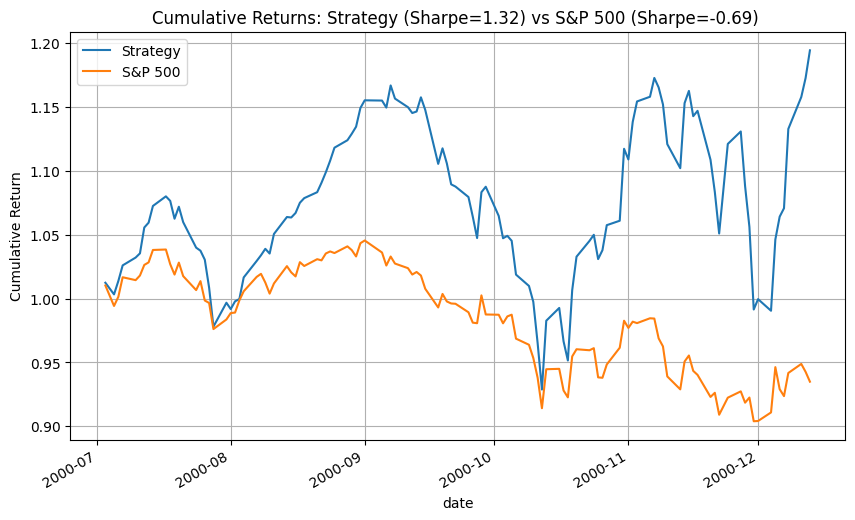

In [6]:
# Plot the cumulative returns of the strategy and compare with the S&P 500 index
cumulative_returns = (1 + combined_returns).cumprod() 
sp_ret = daily.groupby('date')['sprtrn'].mean()

strat_start = unique_months.iloc[6].to_timestamp()
sp_ret = sp_ret.loc[strat_start:]

cumulative_sp500 = (1 + sp_ret).cumprod()

# Combine into a single DataFrame for easy plotting
combined = pd.DataFrame({
    'Strategy': cumulative_returns,
    'S&P 500': cumulative_sp500
})

# Sharpe ratio
strat_sharpe = utils.compute_sharpe(combined_returns)
sp_sharpe = utils.compute_sharpe(sp_ret)

# Plot
combined.plot(figsize=(10, 6), title=f'Cumulative Returns: Strategy (Sharpe={strat_sharpe:.2f}) vs S&P 500 (Sharpe={sp_sharpe:.2f}) ')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

# ------------------------------------------------------------------------------------------------------------------

# Let's add firm characteristics

In [7]:
index = pd.read_csv('Predictors/FirmCharacIndex.csv')
gc.collect()
merged_data = utils.memory_efficient_merge(index, daily)
merged_data = merged_data.drop(columns=['PERMNO_y'])
merged_data = merged_data.rename(columns={'PERMNO_x': 'PERMNO'})
merged_data

Processing PERMNOs: 100%|████████████████| 14465/14465 [00:34<00:00, 414.21it/s]


,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,sprtrn_lag1,year_month,pls_index
0,2000-01-31,7975,10025,3070,0,0.025126,0.025218,0.000000,2000-01,-2.952353
1,2000-02-01,7975,10025,3070,0,0.019608,0.010628,0.025218,2000-02,-2.250024
2,2000-02-02,7975,10025,3070,0,0.030769,-0.000114,0.010628,2000-02,-2.250024
3,2000-02-03,7975,10025,3070,0,0.000000,0.011248,-0.000114,2000-02,-2.250024
4,2000-02-04,7975,10025,3070,0,0.007463,-0.000421,0.011248,2000-02,-2.250024
...,...,...,...,...,...,...,...,...,...,...
1568407,2000-12-06,18404,87759,3860,0,0.006250,-0.018220,0.038922,2000-12,-3.378646
1568408,2000-12-07,18404,87759,3860,0,-0.031056,-0.005853,-0.018220,2000-12,-3.378646
1568409,2000-12-08,18404,87759,3860,0,0.000000,0.019605,-0.005853,2000-12,-3.378646
1568410,2000-12-11,18404,87759,3860,0,0.000000,0.007526,0.019605,2000-12,-3.378646


In [8]:
# Keeping track of the return over all the data
reload(utils)
all_strategy_returns = []

for i in range(0, len(unique_months) - 6):

    # Train on 6 months of data and test on 1 month
    train_start = unique_months.iloc[i]
    train_end = unique_months.iloc[i+5]
    test_month = unique_months.iloc[i+6]

    print(f'Training from {train_start} to {train_end}. Testing on {test_month}.')
    
    # Filter data
    train_mask = (merged_data['year_month'] >= train_start) & (merged_data['year_month'] <= train_end)
    test_mask = merged_data['year_month'] == test_month

    tr_df = merged_data[train_mask].copy()
    te_df = merged_data[test_mask].copy()

    # Prepare the data: construct lagged returns, rolling window averages
    train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)
   
    epochs = 5
    max_weight = 0.05  # No stock >5% weight
    diversification_lambda = 0.01  # Strength of penalty
    temperature = 1.0  # Softmax temperature (lower = more diversification)
    train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions, weights = utils.train_DNN(train_df, test_df, features, cat_features, 
                                                                                                   epochs=epochs, max_weight=max_weight, 
                                                                                                   diversification_lambda=diversification_lambda, 
                                                                                                   temperature=temperature)
    # Deduct transaction costs 
    TC_RATE = 0.003 # 0.30% of traded notional value
    alpha = 100

    test_df['weight'] = weights.values
    test_df['weight_change'] = np.abs(test_df['weight'].diff().fillna(0.0))
    test_df['tc_cost'] = test_df['weight_change'].apply(lambda x: utils.progressive_cost(x, base_tc=TC_RATE, alpha=alpha))
    test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet'] - test_df['tc_cost']
    mean_daily_returns = test_df.groupby('date')['strategy_return'].sum()

    all_strategy_returns.append(mean_daily_returns)
    gc.collect() # Memory clean-up

# Concatenate all windows into one Series
combined_returns = pd.concat(all_strategy_returns)



Training from 2000-01 to 2000-06. Testing on 2000-07.
['sprtrn_lag1', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 372 train batches, 35 test batches


Training:  20%|███████                            | 1/5 [00:14<00:59, 14.83s/it]

Epoch 1/5, Loss: -0.0861, Train fit: 0.0201, Test fit: 0.0117, Avg Weight: 0.0002, Max Weight: 0.0063


Training:  60%|█████████████████████              | 3/5 [00:41<00:27, 13.64s/it]

Epoch 3/5, Loss: -0.1082, Train fit: 0.0447, Test fit: 0.0255, Avg Weight: 0.0002, Max Weight: 0.0177


Training: 100%|███████████████████████████████████| 5/5 [01:09<00:00, 13.99s/it]

Epoch 5/5, Loss: -0.1282, Train fit: 0.0579, Test fit: 0.0372, Avg Weight: 0.0002, Max Weight: 0.0157
Training completed! Best test Sharpe ratio: 0.0372
Training from 2000-02 to 2000-07. Testing on 2000-08.


['sprtrn_lag1', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 438 train batches, 41 test batches


Training:  20%|███████                            | 1/5 [00:16<01:07, 16.90s/it]

Epoch 1/5, Loss: -0.0869, Train fit: 0.0167, Test fit: 0.0499, Avg Weight: 0.0003, Max Weight: 0.0222


Training:  60%|█████████████████████              | 3/5 [00:52<00:35, 17.70s/it]

Epoch 3/5, Loss: -0.1189, Train fit: 0.0427, Test fit: 0.0666, Avg Weight: 0.0003, Max Weight: 0.0400


Training: 100%|███████████████████████████████████| 5/5 [01:23<00:00, 16.72s/it]

Epoch 5/5, Loss: -0.1297, Train fit: 0.0540, Test fit: 0.0659, Avg Weight: 0.0003, Max Weight: 0.0400
Training completed! Best test Sharpe ratio: 0.0666
Training from 2000-03 to 2000-08. Testing on 2000-09.


['sprtrn_lag1', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 448 train batches, 35 test batches


Training:  20%|███████                            | 1/5 [00:17<01:11, 17.92s/it]

Epoch 1/5, Loss: -0.0927, Train fit: 0.0229, Test fit: -0.0095, Avg Weight: 0.0002, Max Weight: 0.0014


Training:  60%|█████████████████████              | 3/5 [00:54<00:36, 18.36s/it]

Epoch 3/5, Loss: -0.1265, Train fit: 0.0506, Test fit: 0.0215, Avg Weight: 0.0002, Max Weight: 0.0027


Training: 100%|███████████████████████████████████| 5/5 [01:29<00:00, 17.92s/it]

Epoch 5/5, Loss: -0.1364, Train fit: 0.0564, Test fit: 0.0284, Avg Weight: 0.0002, Max Weight: 0.0028
Training completed! Best test Sharpe ratio: 0.0284
Training from 2000-04 to 2000-09. Testing on 2000-10.


['sprtrn_lag1', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 438 train batches, 38 test batches


Training:  20%|███████                            | 1/5 [00:14<00:59, 14.80s/it]

Epoch 1/5, Loss: -0.0841, Train fit: 0.0170, Test fit: -0.0115, Avg Weight: 0.0002, Max Weight: 0.0029


Training:  60%|█████████████████████              | 3/5 [00:49<00:33, 16.96s/it]

Epoch 3/5, Loss: -0.1196, Train fit: 0.0524, Test fit: 0.0374, Avg Weight: 0.0002, Max Weight: 0.0031


Training: 100%|███████████████████████████████████| 5/5 [01:23<00:00, 16.69s/it]

Epoch 5/5, Loss: -0.1295, Train fit: 0.0570, Test fit: 0.0435, Avg Weight: 0.0002, Max Weight: 0.0036
Training completed! Best test Sharpe ratio: 0.0435
Training from 2000-05 to 2000-10. Testing on 2000-11.


['sprtrn_lag1', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 447 train batches, 36 test batches


Training:  20%|███████                            | 1/5 [00:16<01:04, 16.05s/it]

Epoch 1/5, Loss: -0.0848, Train fit: 0.0323, Test fit: -0.0366, Avg Weight: 0.0002, Max Weight: 0.0019


Training:  60%|█████████████████████              | 3/5 [00:47<00:31, 15.71s/it]

Epoch 3/5, Loss: -0.1269, Train fit: 0.0565, Test fit: 0.0023, Avg Weight: 0.0002, Max Weight: 0.0027


Training: 100%|███████████████████████████████████| 5/5 [01:16<00:00, 15.38s/it]

Epoch 5/5, Loss: -0.1331, Train fit: 0.0584, Test fit: 0.0102, Avg Weight: 0.0002, Max Weight: 0.0025
Training completed! Best test Sharpe ratio: 0.0102
Training from 2000-06 to 2000-11. Testing on 2000-12.


['sprtrn_lag1', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 442 train batches, 15 test batches


Training:  20%|███████                            | 1/5 [00:14<00:56, 14.10s/it]

Epoch 1/5, Loss: -0.0759, Train fit: 0.0089, Test fit: 0.0725, Avg Weight: 0.0003, Max Weight: 0.0044


Training:  60%|█████████████████████              | 3/5 [00:45<00:30, 15.47s/it]

Epoch 3/5, Loss: -0.1133, Train fit: 0.0490, Test fit: 0.0853, Avg Weight: 0.0003, Max Weight: 0.0047


Training: 100%|███████████████████████████████████| 5/5 [01:16<00:00, 15.24s/it]

Epoch 5/5, Loss: -0.1225, Train fit: 0.0522, Test fit: 0.0916, Avg Weight: 0.0003, Max Weight: 0.0049
Training completed! Best test Sharpe ratio: 0.0916


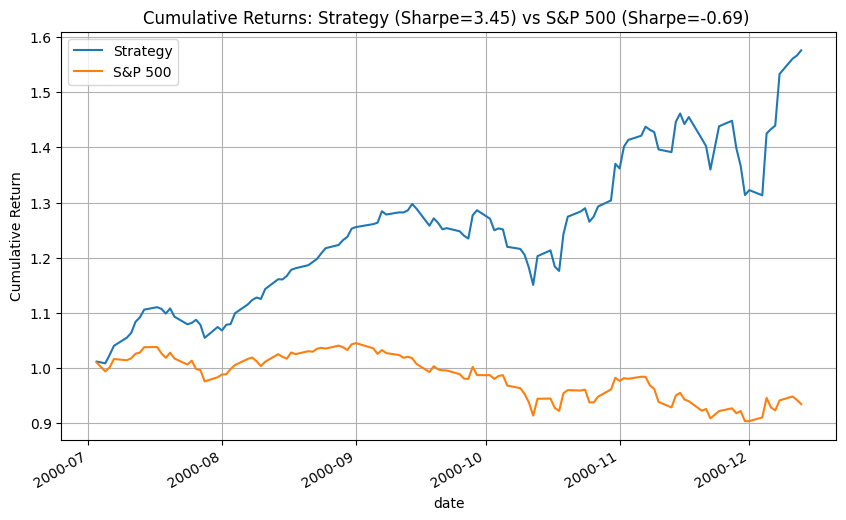

In [9]:
# Plot the cumulative returns of the strategy and compare with the S&P 500 index
cumulative_returns = (1 + combined_returns).cumprod() 
sp_ret = daily.groupby('date')['sprtrn'].mean()

strat_start = unique_months.iloc[6].to_timestamp()
sp_ret = sp_ret.loc[strat_start:]

cumulative_sp500 = (1 + sp_ret).cumprod()

# Combine into a single DataFrame for easy plotting
combined = pd.DataFrame({
    'Strategy': cumulative_returns,
    'S&P 500': cumulative_sp500
})

# Sharpe ratio
strat_sharpe = utils.compute_sharpe(combined_returns)
sp_sharpe = utils.compute_sharpe(sp_ret)

# Plot
combined.plot(figsize=(10, 6), title=f'Cumulative Returns: Strategy (Sharpe={strat_sharpe:.2f}) vs S&P 500 (Sharpe={sp_sharpe:.2f}) ')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

# Let's use linear rank loss instead

In [10]:
# Keeping track of the return over all the data
reload(utils)
all_strategy_returns = []

for i in range(0, len(unique_months) - 6):

    # Train on 6 months of data and test on 1 month
    train_start = unique_months.iloc[i]
    train_end = unique_months.iloc[i+5]
    test_month = unique_months.iloc[i+6]

    print(f'Training from {train_start} to {train_end}. Testing on {test_month}.')
    
    # Filter data
    train_mask = (merged_data['year_month'] >= train_start) & (merged_data['year_month'] <= train_end)
    test_mask = merged_data['year_month'] == test_month

    tr_df = merged_data[train_mask].copy()
    te_df = merged_data[test_mask].copy()

    # Prepare the data: construct lagged returns, rolling window averages
    train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)
   
    epochs = 6 # Optimal trade-off for this strategy
    train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions, weights = utils.train_DNN(train_df, test_df, features, cat_features, 
                                                                                                   epochs=epochs, loss_function = 'lin_rank')
    
    # Deduct transaction costs 
    TC_RATE = 0.003 # 0.30% of traded notional value
    alpha = 100

    test_df['weight'] = weights.values
    test_df['weight_change'] = np.abs(test_df['weight'].diff().fillna(0.0))
    test_df['tc_cost'] = test_df['weight_change'].apply(lambda x: utils.progressive_cost(x, base_tc=TC_RATE, alpha=alpha))
    test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet'] - test_df['tc_cost']
    mean_daily_returns = test_df.groupby('date')['strategy_return'].sum()

    all_strategy_returns.append(mean_daily_returns)
    gc.collect() # Memory clean-up

# Concatenate all windows into one Series
combined_returns = pd.concat(all_strategy_returns)



Training from 2000-01 to 2000-06. Testing on 2000-07.
['sprtrn_lag1', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 372 train batches, 35 test batches


Training:  17%|█████▊                             | 1/6 [00:26<02:14, 27.00s/it]

Epoch 1/6, Loss: -0.0054, Train fit: 0.0122, Test fit: 0.0084, Avg Weight: 0.0002, Max Weight: 0.0119


Training:  50%|█████████████████▌                 | 3/6 [01:15<01:13, 24.64s/it]

Epoch 3/6, Loss: -0.0111, Train fit: 0.0147, Test fit: 0.0125, Avg Weight: 0.0002, Max Weight: 0.0120


Training:  83%|█████████████████████████████▏     | 5/6 [02:05<00:24, 24.82s/it]

Epoch 5/6, Loss: -0.0134, Train fit: 0.0187, Test fit: 0.0133, Avg Weight: 0.0002, Max Weight: 0.0120


Training: 100%|███████████████████████████████████| 6/6 [02:30<00:00, 25.04s/it]

Epoch 6/6, Loss: -0.0175, Train fit: 0.0304, Test fit: 0.0197, Avg Weight: 0.0002, Max Weight: 0.0120
Training completed! Best test Sharpe ratio: 0.0197
Training from 2000-02 to 2000-07. Testing on 2000-08.


['sprtrn_lag1', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 438 train batches, 41 test batches


Training:  17%|█████▊                             | 1/6 [00:28<02:23, 28.78s/it]

Epoch 1/6, Loss: -0.0068, Train fit: 0.0122, Test fit: 0.0311, Avg Weight: 0.0003, Max Weight: 0.1334


Training:  50%|█████████████████▌                 | 3/6 [01:27<01:27, 29.07s/it]

Epoch 3/6, Loss: -0.0121, Train fit: 0.0149, Test fit: 0.0288, Avg Weight: 0.0003, Max Weight: 0.1346


Training:  83%|█████████████████████████████▏     | 5/6 [02:23<00:28, 28.38s/it]

Epoch 5/6, Loss: -0.0164, Train fit: 0.0260, Test fit: 0.0401, Avg Weight: 0.0003, Max Weight: 0.1385


Training: 100%|███████████████████████████████████| 6/6 [02:55<00:00, 29.32s/it]

Epoch 6/6, Loss: -0.0240, Train fit: 0.0305, Test fit: 0.0312, Avg Weight: 0.0003, Max Weight: 0.1385
Training completed! Best test Sharpe ratio: 0.0401
Training from 2000-03 to 2000-08. Testing on 2000-09.


['sprtrn_lag1', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 448 train batches, 35 test batches


Training:  17%|█████▊                             | 1/6 [00:26<02:10, 26.05s/it]

Epoch 1/6, Loss: -0.0108, Train fit: 0.0177, Test fit: 0.0089, Avg Weight: 0.0002, Max Weight: 0.0052


Training:  50%|█████████████████▌                 | 3/6 [01:27<01:28, 29.63s/it]

Epoch 3/6, Loss: -0.0160, Train fit: 0.0230, Test fit: 0.0072, Avg Weight: 0.0002, Max Weight: 0.0052


Training:  83%|█████████████████████████████▏     | 5/6 [02:25<00:29, 29.14s/it]

Epoch 5/6, Loss: -0.0290, Train fit: 0.0354, Test fit: 0.0245, Avg Weight: 0.0002, Max Weight: 0.0052


Training: 100%|███████████████████████████████████| 6/6 [02:55<00:00, 29.18s/it]

Epoch 6/6, Loss: -0.0352, Train fit: 0.0493, Test fit: 0.0357, Avg Weight: 0.0002, Max Weight: 0.0052
Training completed! Best test Sharpe ratio: 0.0357
Training from 2000-04 to 2000-09. Testing on 2000-10.


['sprtrn_lag1', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 438 train batches, 38 test batches


Training:  17%|█████▊                             | 1/6 [00:30<02:31, 30.27s/it]

Epoch 1/6, Loss: -0.0081, Train fit: 0.0155, Test fit: -0.0005, Avg Weight: 0.0002, Max Weight: 0.0145


Training:  50%|█████████████████▌                 | 3/6 [01:28<01:28, 29.61s/it]

Epoch 3/6, Loss: -0.0159, Train fit: 0.0263, Test fit: 0.0092, Avg Weight: 0.0002, Max Weight: 0.0145


Training:  83%|█████████████████████████████▏     | 5/6 [02:29<00:29, 29.98s/it]

Epoch 5/6, Loss: -0.0350, Train fit: 0.0514, Test fit: 0.0538, Avg Weight: 0.0002, Max Weight: 0.0145


Training: 100%|███████████████████████████████████| 6/6 [02:59<00:00, 29.91s/it]

Epoch 6/6, Loss: -0.0451, Train fit: 0.0544, Test fit: 0.0544, Avg Weight: 0.0002, Max Weight: 0.0145
Training completed! Best test Sharpe ratio: 0.0544
Training from 2000-05 to 2000-10. Testing on 2000-11.


['sprtrn_lag1', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 447 train batches, 36 test batches


Training:  17%|█████▊                             | 1/6 [00:27<02:19, 28.00s/it]

Epoch 1/6, Loss: -0.0083, Train fit: 0.0114, Test fit: -0.0084, Avg Weight: 0.0002, Max Weight: 0.0065


Training:  50%|█████████████████▌                 | 3/6 [01:29<01:30, 30.14s/it]

Epoch 3/6, Loss: -0.0105, Train fit: 0.0148, Test fit: -0.0058, Avg Weight: 0.0002, Max Weight: 0.0065


Training:  83%|█████████████████████████████▏     | 5/6 [02:37<00:32, 32.31s/it]

Epoch 5/6, Loss: -0.0138, Train fit: 0.0229, Test fit: 0.0014, Avg Weight: 0.0002, Max Weight: 0.0065


Training: 100%|███████████████████████████████████| 6/6 [03:15<00:00, 32.60s/it]

Epoch 6/6, Loss: -0.0225, Train fit: 0.0342, Test fit: 0.0120, Avg Weight: 0.0002, Max Weight: 0.0065
Training completed! Best test Sharpe ratio: 0.0120
Training from 2000-06 to 2000-11. Testing on 2000-12.


['sprtrn_lag1', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 442 train batches, 15 test batches


Training:  17%|█████▊                             | 1/6 [00:27<02:16, 27.21s/it]

Epoch 1/6, Loss: -0.0033, Train fit: 0.0090, Test fit: 0.0267, Avg Weight: 0.0003, Max Weight: 0.0082


Training:  50%|█████████████████▌                 | 3/6 [01:22<01:23, 27.79s/it]

Epoch 3/6, Loss: -0.0128, Train fit: 0.0264, Test fit: 0.0420, Avg Weight: 0.0003, Max Weight: 0.0082


Training:  83%|█████████████████████████████▏     | 5/6 [02:18<00:27, 27.64s/it]

Epoch 5/6, Loss: -0.0423, Train fit: 0.0546, Test fit: 0.0765, Avg Weight: 0.0003, Max Weight: 0.0082


Training: 100%|███████████████████████████████████| 6/6 [02:45<00:00, 27.51s/it]

Epoch 6/6, Loss: -0.0479, Train fit: 0.0558, Test fit: 0.0769, Avg Weight: 0.0003, Max Weight: 0.0082
Training completed! Best test Sharpe ratio: 0.0769


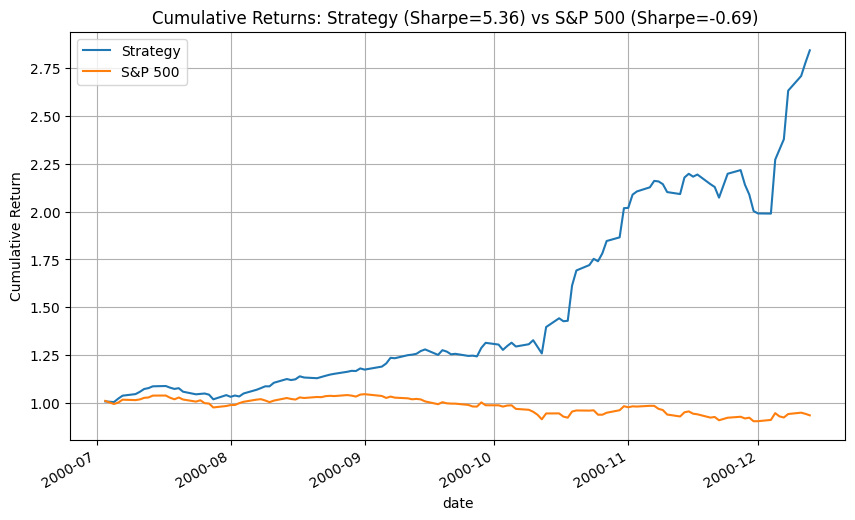

In [11]:
# Plot the cumulative returns of the strategy and compare with the S&P 500 index
cumulative_returns = (1 + combined_returns).cumprod() 
sp_ret = daily.groupby('date')['sprtrn'].mean()

strat_start = unique_months.iloc[6].to_timestamp()
sp_ret = sp_ret.loc[strat_start:]

cumulative_sp500 = (1 + sp_ret).cumprod()

# Combine into a single DataFrame for easy plotting
combined = pd.DataFrame({
    'Strategy': cumulative_returns,
    'S&P 500': cumulative_sp500
})

# Sharpe ratio
strat_sharpe = utils.compute_sharpe(combined_returns)
sp_sharpe = utils.compute_sharpe(sp_ret)

# Plot
combined.plot(figsize=(10, 6), title=f'Cumulative Returns: Strategy (Sharpe={strat_sharpe:.2f}) vs S&P 500 (Sharpe={sp_sharpe:.2f}) ')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

In [12]:
# Keeping track of the return over all the data
reload(utils)
all_strategy_returns = []

for i in range(0, len(unique_months) - 6):

    # Train on 6 months of data and test on 1 month
    train_start = unique_months.iloc[i]
    train_end = unique_months.iloc[i+5]
    test_month = unique_months.iloc[i+6]

    print(f'Training from {train_start} to {train_end}. Testing on {test_month}.')
    
    # Filter data
    train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
    test_mask = daily['year_month'] == test_month

    tr_df = daily[train_mask].copy()
    te_df = daily[test_mask].copy()

    # Prepare the data: construct lagged returns, rolling window averages
    train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)
   
    epochs = 6 # Optimal trade-off for this strategy
    train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions, weights = utils.train_DNN(train_df, test_df, features, cat_features, 
                                                                                                   epochs=epochs, loss_function = 'lin_rank')
    
    # Deduct transaction costs 
    TC_RATE = 0.003 # 0.30% of traded notional value
    alpha = 100

    test_df['weight'] = weights.values
    test_df['weight_change'] = np.abs(test_df['weight'].diff().fillna(0.0))
    test_df['tc_cost'] = test_df['weight_change'].apply(lambda x: utils.progressive_cost(x, base_tc=TC_RATE, alpha=alpha))
    test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet'] - test_df['tc_cost']
    mean_daily_returns = test_df.groupby('date')['strategy_return'].sum()

    all_strategy_returns.append(mean_daily_returns)
    gc.collect() # Memory clean-up

# Concatenate all windows into one Series
combined_returns = pd.concat(all_strategy_returns)



Training from 2000-01 to 2000-06. Testing on 2000-07.
['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 435 train batches, 41 test batches


Training:  17%|█████▊                             | 1/6 [00:28<02:22, 28.59s/it]

Epoch 1/6, Loss: -0.0035, Train fit: 0.0144, Test fit: -0.0053, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  50%|█████████████████▌                 | 3/6 [01:27<01:27, 29.14s/it]

Epoch 3/6, Loss: -0.0194, Train fit: 0.0258, Test fit: 0.0145, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  83%|█████████████████████████████▏     | 5/6 [02:28<00:29, 29.86s/it]

Epoch 5/6, Loss: -0.0367, Train fit: 0.0493, Test fit: 0.0474, Avg Weight: 0.0002, Max Weight: 0.0077


Training: 100%|███████████████████████████████████| 6/6 [02:56<00:00, 29.36s/it]

Epoch 6/6, Loss: -0.0413, Train fit: 0.0517, Test fit: 0.0516, Avg Weight: 0.0002, Max Weight: 0.0077
Training completed! Best test Sharpe ratio: 0.0516
Training from 2000-02 to 2000-07. Testing on 2000-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 512 train batches, 47 test batches


Training:  17%|█████▊                             | 1/6 [00:34<02:50, 34.19s/it]

Epoch 1/6, Loss: -0.0022, Train fit: 0.0112, Test fit: 0.0327, Avg Weight: 0.0002, Max Weight: 0.0049


Training:  50%|█████████████████▌                 | 3/6 [01:42<01:42, 34.11s/it]

Epoch 3/6, Loss: -0.0155, Train fit: 0.0339, Test fit: 0.0438, Avg Weight: 0.0002, Max Weight: 0.0063


Training:  83%|█████████████████████████████▏     | 5/6 [02:45<00:32, 32.72s/it]

Epoch 5/6, Loss: -0.0408, Train fit: 0.0514, Test fit: 0.0638, Avg Weight: 0.0002, Max Weight: 0.0049


Training: 100%|███████████████████████████████████| 6/6 [03:17<00:00, 32.92s/it]

Epoch 6/6, Loss: -0.0444, Train fit: 0.0527, Test fit: 0.0639, Avg Weight: 0.0002, Max Weight: 0.0049
Training completed! Best test Sharpe ratio: 0.0639
Training from 2000-03 to 2000-08. Testing on 2000-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 525 train batches, 41 test batches


Training:  17%|█████▊                             | 1/6 [00:31<02:36, 31.20s/it]

Epoch 1/6, Loss: -0.0045, Train fit: 0.0198, Test fit: 0.0125, Avg Weight: 0.0002, Max Weight: 0.0073


Training:  50%|█████████████████▌                 | 3/6 [01:33<01:33, 31.28s/it]

Epoch 3/6, Loss: -0.0172, Train fit: 0.0228, Test fit: 0.0132, Avg Weight: 0.0002, Max Weight: 0.0073


Training:  83%|█████████████████████████████▏     | 5/6 [02:36<00:31, 31.39s/it]

Epoch 5/6, Loss: -0.0399, Train fit: 0.0474, Test fit: 0.0405, Avg Weight: 0.0002, Max Weight: 0.0073


Training: 100%|███████████████████████████████████| 6/6 [03:10<00:00, 31.76s/it]

Epoch 6/6, Loss: -0.0437, Train fit: 0.0518, Test fit: 0.0442, Avg Weight: 0.0002, Max Weight: 0.0073
Training completed! Best test Sharpe ratio: 0.0442
Training from 2000-04 to 2000-09. Testing on 2000-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 513 train batches, 45 test batches


Training:  17%|█████▊                             | 1/6 [00:29<02:27, 29.48s/it]

Epoch 1/6, Loss: -0.0059, Train fit: 0.0281, Test fit: 0.0144, Avg Weight: 0.0002, Max Weight: 0.0076


Training:  50%|█████████████████▌                 | 3/6 [01:28<01:29, 29.68s/it]

Epoch 3/6, Loss: -0.0277, Train fit: 0.0488, Test fit: 0.0499, Avg Weight: 0.0002, Max Weight: 0.0076


Training:  83%|█████████████████████████████▏     | 5/6 [02:28<00:29, 29.75s/it]

Epoch 5/6, Loss: -0.0456, Train fit: 0.0537, Test fit: 0.0538, Avg Weight: 0.0002, Max Weight: 0.0076


Training: 100%|███████████████████████████████████| 6/6 [02:58<00:00, 29.68s/it]

Epoch 6/6, Loss: -0.0466, Train fit: 0.0529, Test fit: 0.0555, Avg Weight: 0.0002, Max Weight: 0.0076
Training completed! Best test Sharpe ratio: 0.0555
Training from 2000-05 to 2000-10. Testing on 2000-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 525 train batches, 43 test batches


Training:  17%|█████▊                             | 1/6 [00:30<02:30, 30.01s/it]

Epoch 1/6, Loss: -0.0061, Train fit: 0.0170, Test fit: -0.0032, Avg Weight: 0.0002, Max Weight: 0.0152


Training:  50%|█████████████████▌                 | 3/6 [01:30<01:30, 30.00s/it]

Epoch 3/6, Loss: -0.0456, Train fit: 0.0545, Test fit: 0.0300, Avg Weight: 0.0002, Max Weight: 0.0152


Training:  83%|█████████████████████████████▏     | 5/6 [02:30<00:30, 30.11s/it]

Epoch 5/6, Loss: -0.0479, Train fit: 0.0571, Test fit: 0.0316, Avg Weight: 0.0002, Max Weight: 0.0152


Training: 100%|███████████████████████████████████| 6/6 [03:00<00:00, 30.14s/it]

Epoch 6/6, Loss: -0.0495, Train fit: 0.0593, Test fit: 0.0322, Avg Weight: 0.0002, Max Weight: 0.0152
Training completed! Best test Sharpe ratio: 0.0322
Training from 2000-06 to 2000-11. Testing on 2000-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 520 train batches, 18 test batches


Training:  17%|█████▊                             | 1/6 [00:26<02:11, 26.28s/it]

Epoch 1/6, Loss: 0.0018, Train fit: 0.0140, Test fit: 0.0273, Avg Weight: 0.0003, Max Weight: 0.0638


Training:  50%|█████████████████▌                 | 3/6 [01:19<01:19, 26.51s/it]

Epoch 3/6, Loss: -0.0371, Train fit: 0.0483, Test fit: 0.0429, Avg Weight: 0.0003, Max Weight: 0.0635


Training:  83%|█████████████████████████████▏     | 5/6 [02:12<00:26, 26.38s/it]

Epoch 5/6, Loss: -0.0462, Train fit: 0.0520, Test fit: 0.0431, Avg Weight: 0.0003, Max Weight: 0.0635


Training: 100%|███████████████████████████████████| 6/6 [02:38<00:00, 26.39s/it]

Epoch 6/6, Loss: -0.0486, Train fit: 0.0497, Test fit: 0.0421, Avg Weight: 0.0003, Max Weight: 0.0635
Training completed! Best test Sharpe ratio: 0.0435


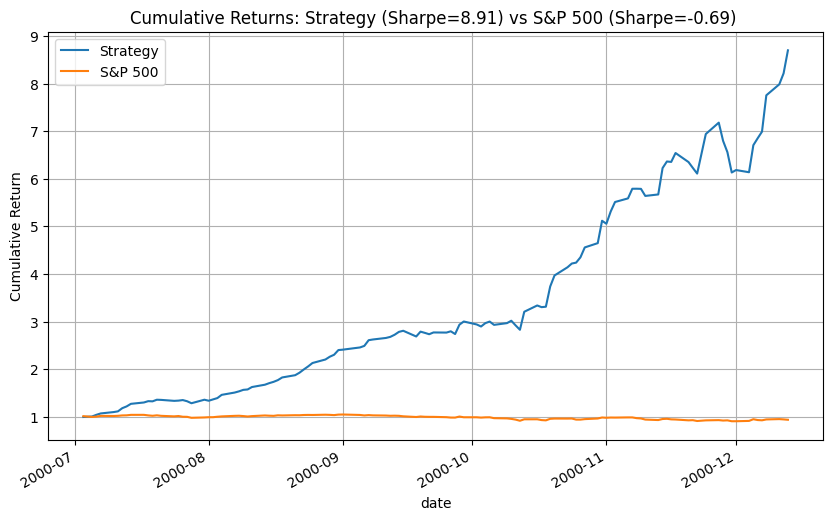

In [13]:
# Plot the cumulative returns of the strategy and compare with the S&P 500 index
cumulative_returns = (1 + combined_returns).cumprod() 
sp_ret = daily.groupby('date')['sprtrn'].mean()

strat_start = unique_months.iloc[6].to_timestamp()
sp_ret = sp_ret.loc[strat_start:]

cumulative_sp500 = (1 + sp_ret).cumprod()

# Combine into a single DataFrame for easy plotting
combined = pd.DataFrame({
    'Strategy': cumulative_returns,
    'S&P 500': cumulative_sp500
})

# Sharpe ratio
strat_sharpe = utils.compute_sharpe(combined_returns)
sp_sharpe = utils.compute_sharpe(sp_ret)

# Plot
combined.plot(figsize=(10, 6), title=f'Cumulative Returns: Strategy (Sharpe={strat_sharpe:.2f}) vs S&P 500 (Sharpe={sp_sharpe:.2f}) ')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()